<a href="https://colab.research.google.com/github/Aditya-y9/ApnaMakaan/blob/main/PostProcessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-33-d7409abc9f84>:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10')


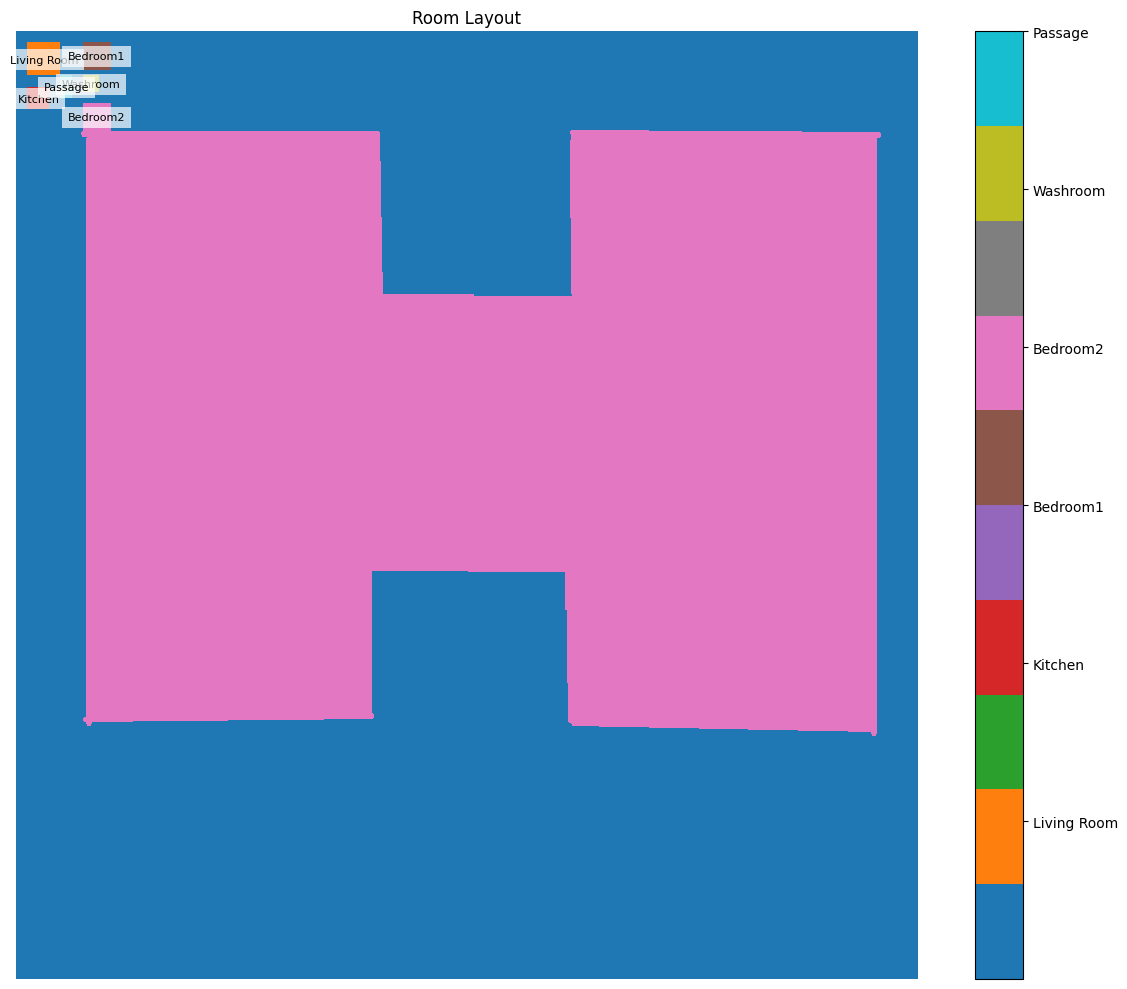

In [33]:
import numpy as np
import matplotlib.pyplot as plt

def load_floor_plan(path):
    # This function should load your floor plan from a file
    # For this example, I'll create a simple function that returns a numpy array
    # In practice, you'd replace this with code to load your actual floor plan
    return np.load(path)

def create_layout(floor_plan, room_definitions):
    height, width = floor_plan.shape
    layout = np.zeros((height, width), dtype=int)

    # First, place all rooms according to their defined positions
    for room in room_definitions:
        y, x, h, w = room['position']
        layout[y:y+h, x:x+w] = room['id']

    # Then, fill any remaining space within the floor plan
    for y in range(height):
        for x in range(width):
            if floor_plan[y, x] == 1 and layout[y, x] == 0:
                # Find the nearest room
                distances = [((y-r['position'][0])**2 + (x-r['position'][1])**2, r['id'])
                             for r in room_definitions]
                nearest_room = min(distances, key=lambda d: d[0])[1]
                layout[y, x] = nearest_room

    return layout

# Load the floor plan
path = "/content/test_plot.png"
floor_plan = floorArray(path)

# Define rooms with their positions (y, x, height, width) and IDs
room_definitions = [
    {'name': 'Living Room', 'position': (10, 10, 30, 30), 'id': 1},
    {'name': 'Kitchen', 'position': (50, 10, 20, 20), 'id': 2},
    {'name': 'Bedroom1', 'position': (10, 60, 25, 25), 'id': 3},
    {'name': 'Bedroom2', 'position': (65, 60, 25, 25), 'id': 4},
    {'name': 'Washroom', 'position': (40, 60, 15, 15), 'id': 5},
    {'name': 'Passage', 'position': (40, 40, 20, 10), 'id': 6}
]

# Create the layout
layout = create_layout(floor_plan, room_definitions)

# Visualization
plt.figure(figsize=(12, 10))
cmap = plt.cm.get_cmap('tab10')
plt.imshow(layout, cmap=cmap, interpolation='nearest')

# Add room labels
for room in room_definitions:
    y, x, h, w = room['position']
    plt.text(x+w//2, y+h//2, room['name'], fontsize=8, ha='center', va='center',
             bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

# Customize colorbar
cbar = plt.colorbar(ticks=range(1, len(room_definitions) + 1))
cbar.set_ticklabels([room['name'] for room in room_definitions])

plt.title("Room Layout")
plt.axis('off')
plt.tight_layout()
plt.show()

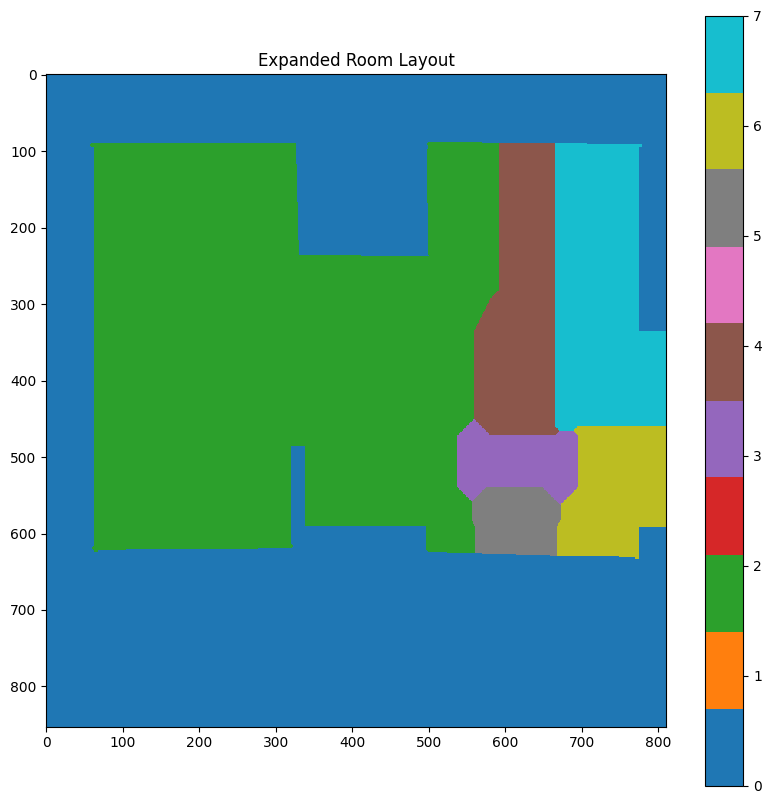

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation

def expand_rooms(room_positions, binary_plot):
    # Create an empty plot
    plot = np.zeros_like(binary_plot, dtype=int)

    # Fill the plot with initial room positions
    for room in room_positions:
        x, y = room['position']
        w, h = room['size']
        plot[y:y+h, x:x+w] = room_type_to_number[room['name']]

    # Create a mask of valid expansion areas (where binary_plot == 1)
    valid_mask = binary_plot == 1

    # Expand rooms
    while np.any((plot == 0) & valid_mask):
        for room in room_positions:
            room_num = room_type_to_number[room['name']]
            mask = plot == room_num

            # Create a structuring element for expansion
            struct = np.array([[0,1,0], [1,1,1], [0,1,0]])

            # Expand the room
            expanded = binary_dilation(mask, structure=struct) & valid_mask

            # Apply expansion only to empty spaces
            plot[(expanded) & (plot == 0) & valid_mask] = room_num

    return plot

# Load the binary plot (floor array)
binary_plot = floorArray(path)

# Expand rooms
expanded_plot = expand_rooms(room_positions, binary_plot)

# Visualize the result
plt.figure(figsize=(10, 10))
plt.imshow(expanded_plot, cmap='tab10', interpolation='nearest')
plt.colorbar()
plt.title("Expanded Room Layout")
plt.show()

Room: Living Room, Centroid: (513.5, 668.0)
Room: Bedroom1, Centroid: (386.0, 714.5)
Room: Bedroom2, Centroid: (204.5, 531.0)
Room: Passage, Centroid: (373.5, 469.0)
Room: Kitchen, Centroid: (413.5, 403.5)
Room: Washroom, Centroid: (277.0, 387.5)


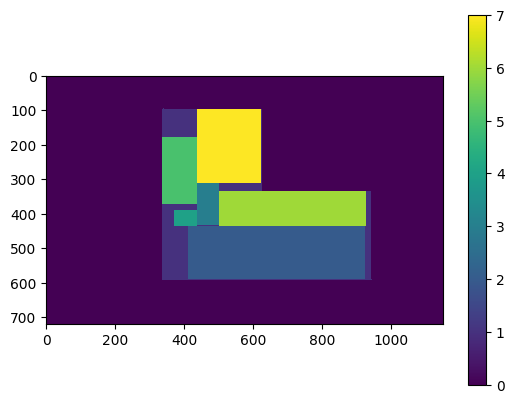

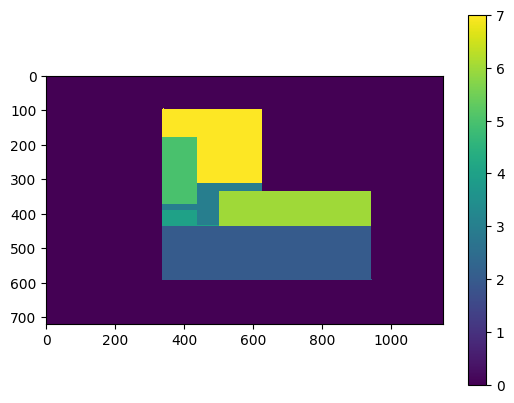

In [36]:
import numpy as np
import json
from pix_array import floorArray
import math
import matplotlib.pyplot as plt
from collections import deque
from scipy.ndimage import measurements
from scipy.spatial.distance import euclidean as euclidean_distance


# Load the binary plot (floor array)
path = "/content/test_plot.png"
binary_plot = floorArray(path)

# Sample room_positions data in the specified format
room_positions1 = [
    {'name': 'Living Room', 'position': (264, 165), 'size': (253, 110)},
    {'name': 'Passage', 'position': (354, 275), 'size': (103, 83)},
    {'name': 'Kitchen', 'position': (248, 278), 'size': (106, 170)},
    {'name': 'Washroom', 'position': (388, 358), 'size': (69, 111)},
    {'name': 'Bedroom1', 'position': (457, 275), 'size': (70, 192)}
]
room_positions2= [
{'name': 'Living Room', 'position': (216, 196), 'size': (143, 102)},
{'name': 'Bedroom1', 'position': (417, 207), 'size': (165, 92)},
{'name': 'Passage', 'position': (359, 185), 'size': (58, 113)},
{'name': 'Kitchen', 'position': (369, 299), 'size': (106, 170)},
{'name': 'Washroom', 'position': (262, 298), 'size': (107, 171)}
]

room_positions3 =[{'name': 'Living Room', 'position': (411, 436), 'size': (514, 155)}, {'name': 'Bedroom1', 'position': (501, 336), 'size': (427, 100)}, {'name': 'Bedroom2', 'position': (437, 97), 'size': (188, 215)}, {'name': 'Passage', 'position': (437, 312), 'size': (64, 123)}, {'name': 'Kitchen', 'position': (370, 391), 'size': (67, 45)}, {'name': 'Washroom', 'position': (338, 180), 'size': (99, 194)}]
# Room type to number mapping
room_type_to_number = {
    "Living Room": 2,
    "Passage": 3,
    "Kitchen": 4,
    "Washroom": 5,
    "Bedroom1": 6,
    "Bedroom2": 7
}
room_positions=room_positions3

# Function to calculate room boundaries
# Function to update the plot array with room number

def calculate_centroids(room_positions):
    centroids = []
    for room in room_positions:
        name = room['name']
        min_x, min_y = room['position']
        size_x, size_y = room['size']
        centroid_x = min_x + size_x / 2
        centroid_y = min_y + size_y / 2
        centroids.append({'name': name, 'centroid': (centroid_y, centroid_x)})
    return centroids

# Calculate the centroids
centroids = calculate_centroids(room_positions)
def euclidean_distance(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

# Print the centroids
for centroid in centroids:
    print(f"Room: {centroid['name']}, Centroid: {centroid['centroid']}")


def update_plot_with_rooms(plot, room_positions, room_type_to_number):
    for room in room_positions:
        room_name = room['name']
        number = room_type_to_number[room_name]
        x, y = map(int, room['position'])
        length, breadth = map(int, room['size'])

        for i in range(y, y + breadth):
            for j in range(x, x + length):
                plot[i, j] = number

def expand_rooms_to_fill_voids(pixel_array):
    rows, cols = pixel_array.shape
    filled_array = pixel_array.copy()

    while True:
        changes_made = False
        new_filled_array = filled_array.copy()

        for r in range(rows):
            for c in range(cols):
                if filled_array[r, c] == 1:  # If the pixel is part of a void
                    # Check the nearest room vertically and horizontally
                    nearest_room_val = None
                    min_distance = float('inf')

                    # Check vertically
                    for vr in range(rows):
                        if filled_array[vr, c] > 1:
                            distance = abs(vr - r)
                            if distance < min_distance:
                                min_distance = distance
                                nearest_room_val = filled_array[vr, c]

                    # Check horizontally
                    for hc in range(cols):
                        if filled_array[r, hc] > 1:
                            distance = abs(hc - c)
                            if distance < min_distance:
                                min_distance = distance
                                nearest_room_val = filled_array[r, hc]

                    if nearest_room_val:
                        new_filled_array[r, c] = nearest_room_val
                        changes_made = True

        if not changes_made:
            break

        filled_array = new_filled_array

    return filled_array
def get_room_details(room_positions, room_name):
    for room in room_positions:
        if room['name'] == room_name:
            return room['position'], room['size']

def extend_boundaries(binary_plot,room_positions, room_type_to_number):
    x,y = binary_plot.shape
    filled_array = binary_plot.copy()
    for i in range(x):
        for j in range(y):
            if binary_plot[i][j] == 1:
                centroid_distances = []

                # Calculate distances from current (i, j) to centroids
                for centroid in centroids:
                    centroid_coords = centroid['centroid']
                    distance = euclidean_distance((i, j), centroid_coords)
                    centroid_distances.append((distance, centroid))

                # Sort centroids by distance in ascending order
                centroid_distances.sort(key=lambda x: x[0])

                # Find the nearest room and assign its type to binary_plot[i][j]
                for distance, centroid in centroid_distances:
                    position, size = get_room_details(room_positions, centroid['name'])
                    y_room, x_room = position
                    length, breadth = size

                    # Check if (i, j) is within the boundaries of the current room
                    if (i >= x_room and i < x_room + breadth) or (j <= y_room and j > y_room + length):
                        filled_array[i][j] = room_type_to_number.get(centroid['name'])
                        break

    return filled_array

# Update the plot with room numbers
update_plot_with_rooms(binary_plot, room_positions, room_type_to_number)
plt.imshow(binary_plot, interpolation='nearest')
plt.colorbar()
plt.show()

filled_plot= extend_boundaries(binary_plot,room_positions, room_type_to_number)

filled_plot= expand_rooms_to_fill_voids(filled_plot)
# Save the updated plot array to a file
np.savetxt('filled_plot.txt', binary_plot, fmt='%d')

# Visualize the updated array (optional)

plt.imshow(filled_plot, interpolation='nearest')
plt.colorbar()
plt.show()

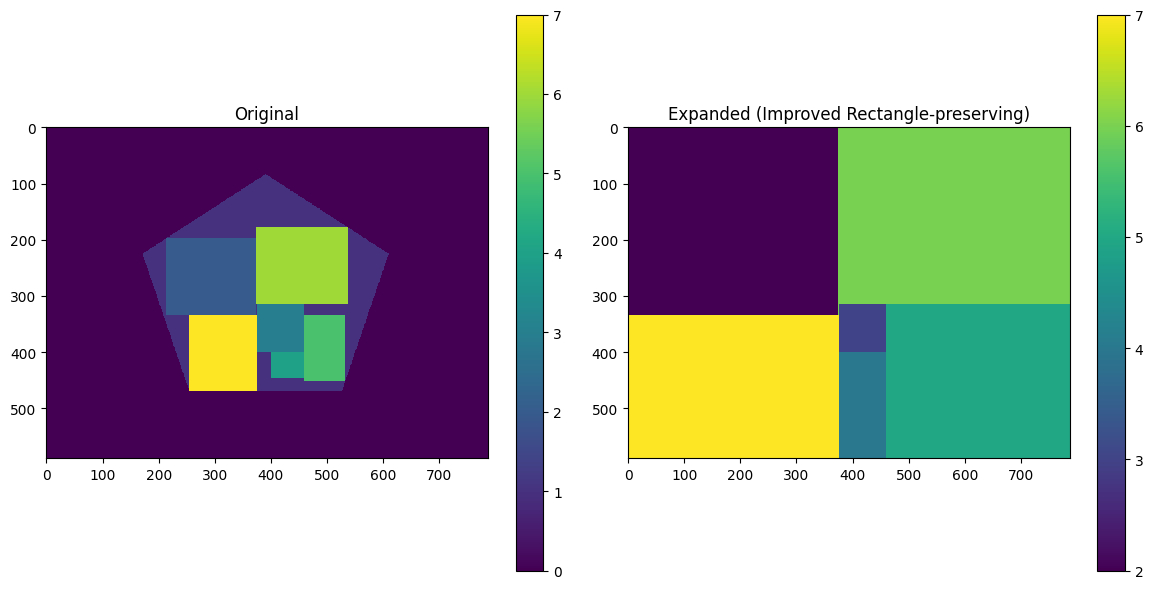

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, box

def expand_rooms_rectangle_preserving(binary_plot, room_positions, room_type_to_number):
    height, width = binary_plot.shape
    plot_polygon = Polygon([(0, 0), (0, height), (width, height), (width, 0)])

    expanded_rooms = []
    for room in room_positions:
        x, y = room['position']
        w, h = room['size']
        room_num = room_type_to_number[room['name']]
        expanded_rooms.append({
            'polygon': box(x, y, x+w, y+h),
            'number': room_num
        })

    # Sort rooms by size (largest first)
    expanded_rooms.sort(key=lambda r: r['polygon'].area, reverse=True)

    # Expand rooms
    for i, room in enumerate(expanded_rooms):
        while True:
            expanded = False
            for direction in ['right', 'left', 'down', 'up']:
                new_polygon = expand_in_direction(room['polygon'], direction)
                if new_polygon.within(plot_polygon) and all(not new_polygon.overlaps(other['polygon']) for j, other in enumerate(expanded_rooms) if i != j):
                    room['polygon'] = new_polygon
                    expanded = True
                    break
            if not expanded:
                break

    # Fill gaps
    remaining_space = plot_polygon
    for room in expanded_rooms:
        remaining_space = remaining_space.difference(room['polygon'])

    if not remaining_space.is_empty:
        for part in remaining_space.geoms if hasattr(remaining_space, 'geoms') else [remaining_space]:
            closest_room = min(expanded_rooms, key=lambda r: r['polygon'].distance(part))
            closest_room['polygon'] = closest_room['polygon'].union(part)

    result = np.zeros_like(binary_plot)
    for room in expanded_rooms:
        x, y, w, h = room['polygon'].bounds
        x, y, w, h = map(int, (x, y, w, h))
        result[y:h, x:w] = room['number']

    return result

def expand_in_direction(polygon, direction):
    minx, miny, maxx, maxy = polygon.bounds
    if direction == 'right':
        return box(minx, miny, maxx + 1, maxy)
    elif direction == 'left':
        return box(minx - 1, miny, maxx, maxy)
    elif direction == 'down':
        return box(minx, miny, maxx, maxy + 1)
    elif direction == 'up':
        return box(minx, miny - 1, maxx, maxy)

# Assuming you have binary_plot, room_positions, and room_type_to_number defined

# Expand rooms using the improved rectangle-preserving approach
expanded_array = expand_rooms_rectangle_preserving(binary_plot, room_positions, room_type_to_number)

# Visualize the result
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(binary_plot, interpolation='nearest')
plt.title("Original")
plt.colorbar()

plt.subplot(122)
plt.imshow(expanded_array, interpolation='nearest')
plt.title("Expanded (Improved Rectangle-preserving)")
plt.colorbar()

plt.tight_layout()
plt.show()

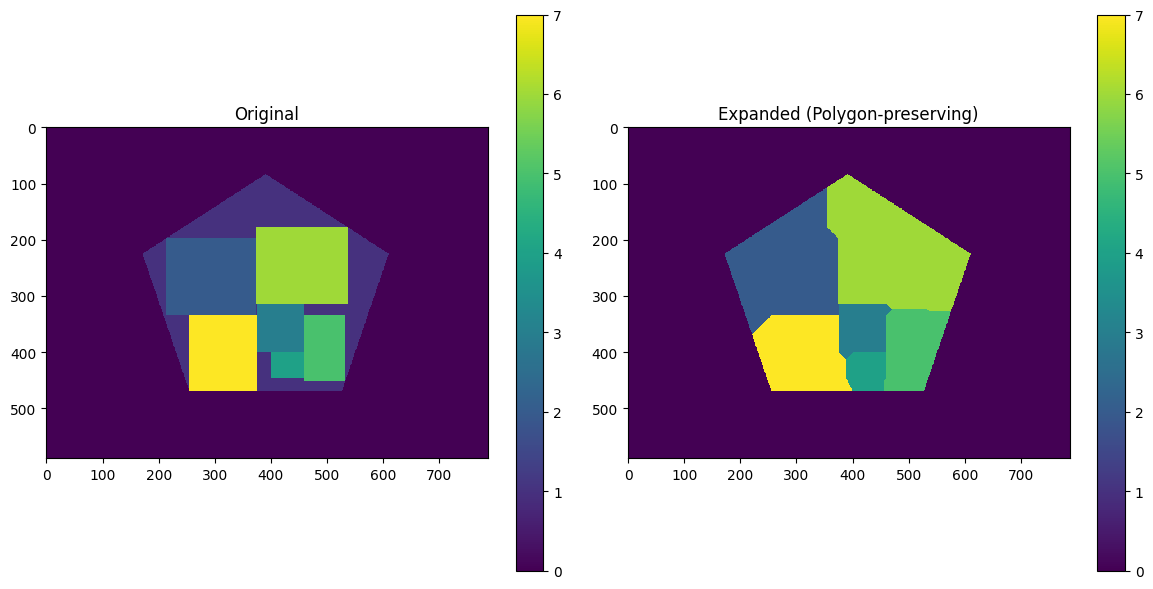

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def expand_rooms_in_polygon(binary_plot, room_positions, room_type_to_number):
    result = np.zeros_like(binary_plot)

    # Initialize rooms
    for room in room_positions:
        x, y = map(int, room['position'])
        w, h = map(int, room['size'])
        room_num = room_type_to_number[room['name']]
        result[y:y+h, x:x+w] = room_num

    # Expand rooms
    while np.any((binary_plot != 0) & (result == 0)):
        for room_num in range(2, max(room_type_to_number.values()) + 1):
            room_mask = result == room_num
            expand_mask = np.zeros_like(binary_plot, dtype=bool)

            # Check four directions
            expand_mask[1:] |= room_mask[:-1]
            expand_mask[:-1] |= room_mask[1:]
            expand_mask[:, 1:] |= room_mask[:, :-1]
            expand_mask[:, :-1] |= room_mask[:, 1:]

            # Apply expansion
            expand_area = expand_mask & (binary_plot != 0) & (result == 0)
            result[expand_area] = room_num

    return result

# Assuming you have binary_plot, room_positions, and room_type_to_number defined

# Expand rooms using the polygon-preserving approach
expanded_array = expand_rooms_in_polygon(binary_plot, room_positions, room_type_to_number)

# Visualize the result
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(binary_plot, interpolation='nearest')
plt.title("Original")
plt.colorbar()

plt.subplot(122)
plt.imshow(expanded_array, interpolation='nearest')
plt.title("Expanded (Polygon-preserving)")
plt.colorbar()

plt.tight_layout()
plt.show()

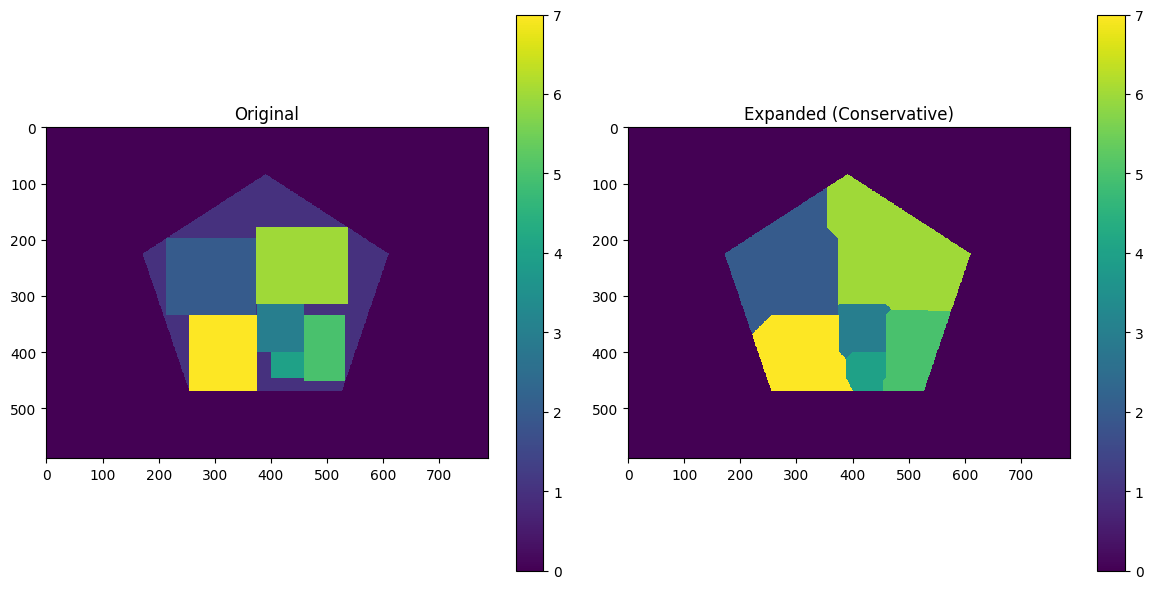

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def expand_rooms_conservatively(binary_plot, room_positions, room_type_to_number):
    result = np.zeros_like(binary_plot)
    height, width = binary_plot.shape

    # Initialize rooms
    for room in room_positions:
        x, y = map(int, room['position'])
        w, h = map(int, room['size'])
        room_num = room_type_to_number[room['name']]
        result[y:y+h, x:x+w] = room_num

    # Create a mask of expandable area
    expandable = (binary_plot != 0) & (result == 0)

    # Expand rooms
    while np.any(expandable):
        for room_num in range(2, max(room_type_to_number.values()) + 1):
            room_mask = result == room_num

            # Check four directions
            expand_right = room_mask[:, :-1] & expandable[:, 1:]
            expand_left = room_mask[:, 1:] & expandable[:, :-1]
            expand_down = room_mask[:-1, :] & expandable[1:, :]
            expand_up = room_mask[1:, :] & expandable[:-1, :]

            # Apply expansion
            result[:, 1:][expand_right] = room_num
            result[:, :-1][expand_left] = room_num
            result[1:, :][expand_down] = room_num
            result[:-1, :][expand_up] = room_num

        # Update expandable area
        expandable = (binary_plot != 0) & (result == 0)

    return result

# Assuming you have binary_plot, room_positions, and room_type_to_number defined

# Expand rooms using the conservative approach
expanded_array = expand_rooms_conservatively(binary_plot, room_positions, room_type_to_number)

# Visualize the result
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(binary_plot, interpolation='nearest')
plt.title("Original")
plt.colorbar()

plt.subplot(122)
plt.imshow(expanded_array, interpolation='nearest')
plt.title("Expanded (Conservative)")
plt.colorbar()

plt.tight_layout()
plt.show()

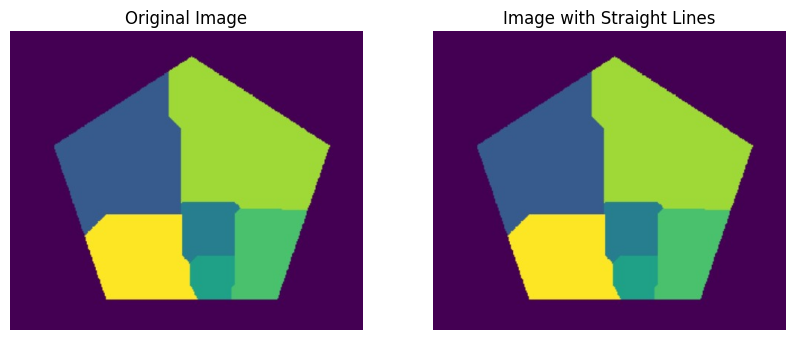

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the image
image_path = '/content/image.jpg'
image = cv2.imread(image_path)

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply thresholding
_, thresh = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)

# Find contours
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create an empty image to draw straightened lines
straight_lines = np.zeros_like(image)

# Iterate through contours and approximate each contour with a polygon
for contour in contours:
    epsilon = 0.01 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    cv2.drawContours(straight_lines, [approx], -1, (255, 255, 255), thickness=cv2.FILLED)

# Combine the straight lines with the original image
result = cv2.bitwise_and(image, straight_lines)

# Plot the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Image with Straight Lines')
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()


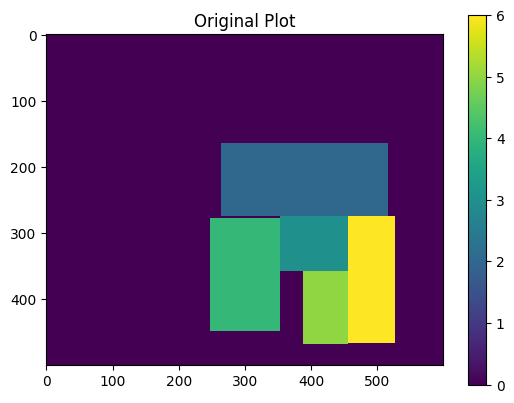

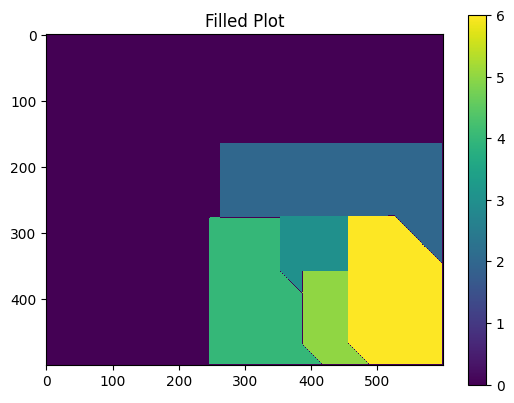

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Sample room_positions data in the specified format
room_positions1 = [
    {'name': 'Living Room', 'position': (264, 165), 'size': (253, 110)},
    {'name': 'Passage', 'position': (354, 275), 'size': (103, 83)},
    {'name': 'Kitchen', 'position': (248, 278), 'size': (106, 170)},
    {'name': 'Washroom', 'position': (388, 358), 'size': (69, 111)},
    {'name': 'Bedroom1', 'position': (457, 275), 'size': (70, 192)}
]

room_positions2 = [
    {'name': 'Living Room', 'position': (216, 196), 'size': (143, 102)},
    {'name': 'Bedroom1', 'position': (417, 207), 'size': (165, 92)},
    {'name': 'Passage', 'position': (359, 185), 'size': (58, 113)},
    {'name': 'Kitchen', 'position': (369, 299), 'size': (106, 170)},
    {'name': 'Washroom', 'position': (262, 298), 'size': (107, 171)}
]

room_positions3 = [
    {'name': 'Living Room', 'position': (221, 193), 'size': (171, 112)},
    {'name': 'Bedroom1', 'position': (255, 305), 'size': (137, 164)},
    {'name': 'Passage', 'position': (392, 251), 'size': (157, 103)},
    {'name': 'Kitchen', 'position': (420, 354), 'size': (72, 115)},
    {'name': 'Washroom', 'position': (492, 355), 'size': (47, 76)},
]

# Room type to number mapping
room_type_to_number = {
    "Living Room": 2,
    "Passage": 3,
    "Kitchen": 4,
    "Washroom": 5,
    "Bedroom1": 6
}

room_positions = room_positions1  # Select which set of room positions to use

# Function to calculate room boundaries
def calculate_centroids(room_positions):
    centroids = []
    for room in room_positions:
        name = room['name']
        min_x, min_y = room['position']
        size_x, size_y = room['size']
        centroid_x = min_x + size_x / 2
        centroid_y = min_y + size_y / 2
        centroids.append({'name': name, 'centroid': (centroid_y, centroid_x)})
    return centroids

# Calculate the centroids
centroids = calculate_centroids(room_positions)

# Function to update the plot array with room number
def update_plot_with_rooms(plot, room_positions, room_type_to_number):
    for room in room_positions:
        room_name = room['name']
        number = room_type_to_number[room_name]
        x, y = map(int, room['position'])
        length, breadth = map(int, room['size'])

        for i in range(y, y + breadth):
            for j in range(x, x + length):
                plot[i, j] = number

# Function to expand rooms to fill voids without erasing room boundaries
def expand_rooms_to_fill_voids(pixel_array):
    rows, cols = pixel_array.shape
    filled_array = pixel_array.copy()

    for r in range(1, rows - 1):
        for c in range(1, cols - 1):
            if filled_array[r, c] == 0:  # If the pixel is part of a void
                neighbors = [
                    filled_array[r - 1, c], filled_array[r + 1, c],  # Top and bottom
                    filled_array[r, c - 1], filled_array[r, c + 1]   # Left and right
                ]
                neighbor_values = [n for n in neighbors if n != 0]
                if neighbor_values:
                    # Ensure the pixel is surrounded by the same room number
                    unique_neighbors = set(neighbor_values)
                    if len(unique_neighbors) == 1:
                        filled_array[r, c] = neighbor_values[0]

    return filled_array

# Load the binary plot (floor array)
# Replace this with your actual method of loading or generating the binary plot
binary_plot = np.zeros((500, 600), dtype=int)

# Update the plot with room numbers
update_plot_with_rooms(binary_plot, room_positions, room_type_to_number)

# Visualize the original plot
plt.imshow(binary_plot, interpolation='nearest')
plt.colorbar()
plt.title('Original Plot')
plt.show()

# Expand rooms to fill voids
filled_plot = expand_rooms_to_fill_voids(binary_plot)

# Visualize the filled plot
plt.imshow(filled_plot, interpolation='nearest')
plt.colorbar()
plt.title('Filled Plot')
plt.show()

# Save the updated plot array to a file
np.savetxt('filled_plot.txt', filled_plot, fmt='%d')


Room: Living Room, Centroid: (220.0, 390.5)
Room: Passage, Centroid: (316.5, 405.5)
Room: Kitchen, Centroid: (363.0, 301.0)
Room: Washroom, Centroid: (413.5, 422.5)
Room: Bedroom1, Centroid: (371.0, 492.0)


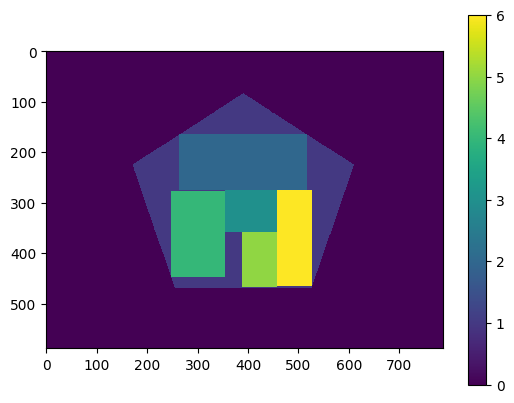

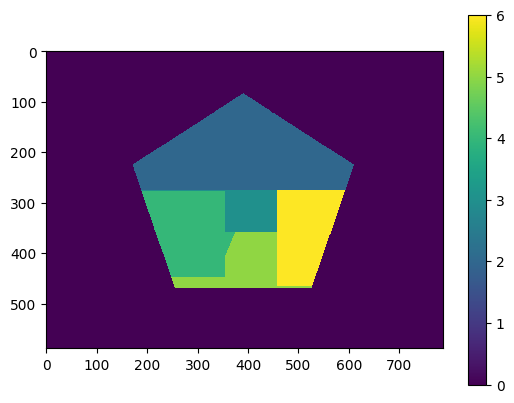

In [ ]:
import numpy as np
import json
from pix_array import floorArray
import math
import matplotlib.pyplot as plt
from collections import deque
from scipy.ndimage import measurements
from scipy.spatial.distance import euclidean as euclidean_distance


# Load the binary plot (floor array)
path = "/content/test_plot.png"
binary_plot = floorArray(path)

# Sample room_positions data in the specified format
room_positions1 = [
    {'name': 'Living Room', 'position': (264, 165), 'size': (253, 110)},
    {'name': 'Passage', 'position': (354, 275), 'size': (103, 83)},
    {'name': 'Kitchen', 'position': (248, 278), 'size': (106, 170)},
    {'name': 'Washroom', 'position': (388, 358), 'size': (69, 111)},
    {'name': 'Bedroom1', 'position': (457, 275), 'size': (70, 192)}
]
room_positions2= [
{'name': 'Living Room', 'position': (216, 196), 'size': (143, 102)},
{'name': 'Bedroom1', 'position': (417, 207), 'size': (165, 92)},
{'name': 'Passage', 'position': (359, 185), 'size': (58, 113)},
{'name': 'Kitchen', 'position': (369, 299), 'size': (106, 170)},
{'name': 'Washroom', 'position': (262, 298), 'size': (107, 171)}
]

room_positions3=[
{'name': 'Living Room', 'position': (221, 193), 'size': (171, 112)},
{'name': 'Bedroom1', 'position': (255, 305), 'size': (137, 164)},
{'name': 'Passage', 'position': (392, 251), 'size': (157, 103)},
{'name': 'Kitchen', 'position': (420, 354), 'size': (72, 115)},
{'name': 'Washroom', 'position': (492, 355), 'size': (47, 76)},

]

# Room type to number mapping
room_type_to_number = {
    "Living Room": 2,
    "Passage": 3,
    "Kitchen": 4,
    "Washroom": 5,
    "Bedroom1": 6
}
room_positions=room_positions1

# Function to calculate room boundaries
# Function to update the plot array with room number

def calculate_centroids(room_positions):
    centroids = []
    for room in room_positions:
        name = room['name']
        min_x, min_y = room['position']
        size_x, size_y = room['size']
        centroid_x = min_x + size_x / 2
        centroid_y = min_y + size_y / 2
        centroids.append({'name': name, 'centroid': (centroid_y, centroid_x)})
    return centroids

# Calculate the centroids
centroids = calculate_centroids(room_positions)
def euclidean_distance(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

# Print the centroids
for centroid in centroids:
    print(f"Room: {centroid['name']}, Centroid: {centroid['centroid']}")


def update_plot_with_rooms(plot, room_positions, room_type_to_number):
    for room in room_positions:
        room_name = room['name']
        number = room_type_to_number[room_name]
        x, y = map(int, room['position'])
        length, breadth = map(int, room['size'])

        for i in range(y, y + breadth):
            for j in range(x, x + length):
                plot[i, j] = number

def expand_rooms_to_fill_voids(pixel_array):
    rows, cols = pixel_array.shape
    filled_array = pixel_array.copy()

    while True:
        changes_made = False
        new_filled_array = filled_array.copy()

        for r in range(rows):
            for c in range(cols):
                if filled_array[r, c] == 1:  # If the pixel is part of a void
                    # Check the nearest room vertically and horizontally
                    nearest_room_val = None
                    min_distance = float('inf')

                    # Check vertically
                    for vr in range(rows):
                        if filled_array[vr, c] > 1:
                            distance = abs(vr - r)
                            if distance < min_distance:
                                min_distance = distance
                                nearest_room_val = filled_array[vr, c]

                    # Check horizontally
                    for hc in range(cols):
                        if filled_array[r, hc] > 1:
                            distance = abs(hc - c)
                            if distance < min_distance:
                                min_distance = distance
                                nearest_room_val = filled_array[r, hc]

                    if nearest_room_val:
                        new_filled_array[r, c] = nearest_room_val
                        changes_made = True

        if not changes_made:
            break

        filled_array = new_filled_array

    return filled_array
def get_room_details(room_positions, room_name):
    for room in room_positions:
        if room['name'] == room_name:
            return room['position'], room['size']

def extend_boundaries(binary_plot,room_positions, room_type_to_number):
    x,y = binary_plot.shape
    filled_array = binary_plot.copy()
    for i in range(x):
        for j in range(y):
            if binary_plot[i][j] == 1:
                centroid_distances = []

                # Calculate distances from current (i, j) to centroids
                for centroid in centroids:
                    centroid_coords = centroid['centroid']
                    distance = euclidean_distance((i, j), centroid_coords)
                    centroid_distances.append((distance, centroid))

                # Sort centroids by distance in ascending order
                centroid_distances.sort(key=lambda x: x[0])

                # Find the nearest room and assign its type to binary_plot[i][j]
                for distance, centroid in centroid_distances:
                    position, size = get_room_details(room_positions, centroid['name'])
                    y_room, x_room = position
                    length, breadth = size

                    # Check if (i, j) is within the boundaries of the current room
                    if (i >= x_room and i < x_room + breadth) or (j <= y_room and j > y_room + length):
                        filled_array[i][j] = room_type_to_number.get(centroid['name'])
                        break

    return filled_array

# Update the plot with room numbers
update_plot_with_rooms(binary_plot, room_positions, room_type_to_number)
plt.imshow(binary_plot, interpolation='nearest')
plt.colorbar()
plt.show()

filled_plot= extend_boundaries(binary_plot,room_positions, room_type_to_number)

filled_plot= expand_rooms_to_fill_voids(filled_plot)
# Save the updated plot array to a file
np.savetxt('filled_plot.txt', binary_plot, fmt='%d')

# Visualize the updated array (optional)

plt.imshow(filled_plot, interpolation='nearest')
plt.colorbar()
plt.show()